In [0]:
import os
import glob

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2

from keras.preprocessing import image
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import MaxPooling2D, Dropout, UpSampling2D

In [0]:
%matplotlib inline

(420, 540)


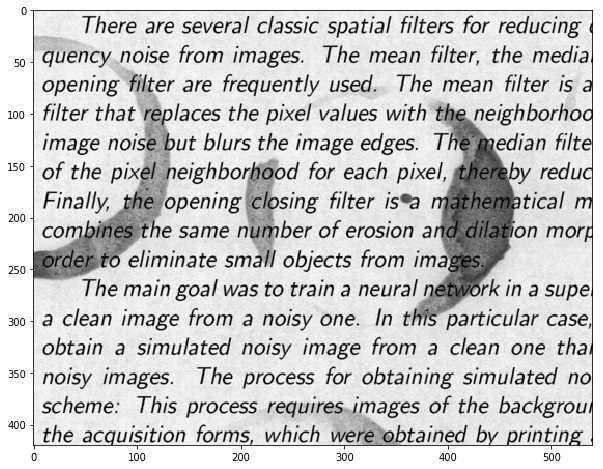

In [46]:
plt.figure(figsize=(20,8))
img = cv2.imread('/content/train/171.png', 0)
plt.imshow(img, cmap='gray')
print(img.shape)

In [0]:
TRAIN_IMAGES = glob.glob('/content/train/*.png')
CLEAN_IMAGES = glob.glob('/content/train_cleaned/*.png')
TEST_IMAGES = glob.glob('/content/test/*.png')

In [0]:
def load_image(path):
    image_list = np.zeros((len(path), 258, 540, 1))
    for i, fig in enumerate(path):
        img = image.load_img(fig, color_mode='grayscale', target_size=(258, 540))
        x = image.img_to_array(img).astype('float32')
        x = x / 255.0
        image_list[i] = x
    
    return image_list


In [49]:
x_train = load_image(TRAIN_IMAGES)
y_train = load_image(CLEAN_IMAGES)
x_test = load_image(TEST_IMAGES)

print(x_train.shape, x_test.shape)

(144, 258, 540, 1) (72, 258, 540, 1)


In [50]:
def train_val_split(x_train, y_train):
    rnd = np.random.RandomState(seed=42)
    perm = rnd.permutation(len(x_train))
    train_idx = perm[:int(0.8 * len(x_train))]
    val_idx = perm[int(0.8 * len(x_train)):]
    return x_train[train_idx], y_train[train_idx], x_train[val_idx], y_train[val_idx]

x_train, y_train, x_val, y_val = train_val_split(x_train, y_train)
print(x_train.shape, x_val.shape)

(115, 258, 540, 1) (29, 258, 540, 1)


In [0]:
class Autoencoder():
    def __init__(self):
        self.img_rows = 258
        self.img_cols = 540
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        
        optimizer = Adam(lr=0.001)
        
        self.autoencoder_model = self.build_model()
        self.autoencoder_model.compile(loss='mse', optimizer=optimizer)
        self.autoencoder_model.summary()
    
    def build_model(self):
        input_layer = Input(shape=self.img_shape)
        
        # encoder
        h = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
        h = MaxPooling2D((2, 2), padding='same')(h)
        
        # decoder
        h = Conv2D(64, (3, 3), activation='relu', padding='same')(h)
        h = UpSampling2D((2, 2))(h)
        output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(h)
        
        return Model(input_layer, output_layer)
    
    def train_model(self, x_train, y_train, x_val, y_val, epochs, batch_size=20):
        early_stopping = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=5,
                                       verbose=1, 
                                       mode='auto')
        history = self.autoencoder_model.fit(x_train, y_train,
                                             batch_size=batch_size,
                                             epochs=epochs,
                                             validation_data=(x_val, y_val),
                                             callbacks=[early_stopping])
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()
    
    def eval_model(self, x_test):
        preds = self.autoencoder_model.predict(x_test)
        return preds

W0727 18:12:26.658298 140222135916416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0727 18:12:26.659861 140222135916416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0727 18:12:26.663717 140222135916416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0727 18:12:26.694696 140222135916416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0727 18:12:26.711973 140222135916416 deprecation_wrapp

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 258, 540, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 258, 540, 64)      640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 129, 270, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 129, 270, 64)      36928     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 258, 540, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 258, 540, 1)       577       
Total params: 38,145
Trainable params: 38,145
Non-trainable params: 0
_________________________________________________________________


W0727 18:12:27.051613 140222135916416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 115 samples, validate on 29 samples
Epoch 1/200
115/115 [==============================] - 11s 97ms/step - loss: 0.1649 - val_loss: 0.0901
Epoch 2/200
115/115 [==============================] - 1s 11ms/step - loss: 0.0753 - val_loss: 0.0734
Epoch 3/200
115/115 [==============================] - 1s 11ms/step - loss: 0.0747 - val_loss: 0.0754
Epoch 4/200
115/115 [==============================] - 1s 11ms/step - loss: 0.0730 - val_loss: 0.0670
Epoch 5/200
115/115 [==============================] - 1s 11ms/step - loss: 0.0642 - val_loss: 0.0622
Epoch 6/200
115/115 [==============================] - 1s 11ms/step - loss: 0.0585 - val_loss: 0.0552
Epoch 7/200
115/115 [==============================] - 1s 11ms/step - loss: 0.0516 - val_loss: 0.0471
Epoch 8/200
115/115 [==============================] - 1s 11ms/step - loss: 0.0436 - val_loss: 0.0384
Epoch 9/200
115/115 [==============================] - 1s 11ms/step - loss: 0.0365 - val_loss: 0.0326
Epoch 10/200
115/115 [==============

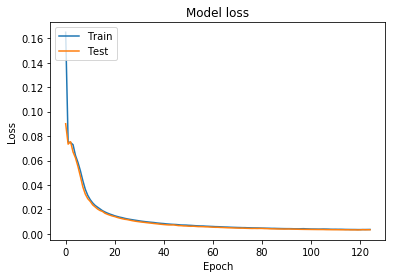

In [29]:
ae = Autoencoder()
ae.train_model(x_train, y_train, x_val, y_val, epochs=200, batch_size=20)

In [0]:
preds = ae.eval_model(x_test)

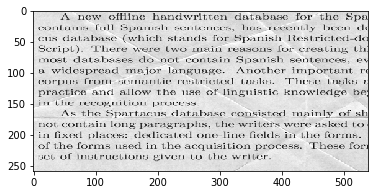

In [40]:
preds_0 = preds[5] * 255.0
preds_0 = preds_0.reshape(258, 540)
x_test_0 = x_test[5] * 255.0
x_test_0 = x_test_0.reshape(258, 540)
plt.imshow(x_test_0, cmap='gray')

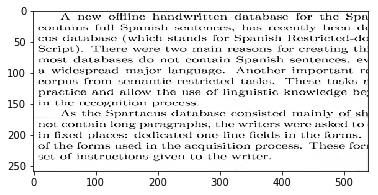

In [41]:
plt.imshow(preds_0, cmap='gray')